# Deep Reinforcement Learning Pairs Trading

## 1. Importing Libraries:

In [152]:
pip install pandas numpy matplotlib yfinance gym stable-baselines3 scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [153]:
pip install gymnasium

Note: you may need to restart the kernel to use updated packages.


## 2. Data Collection:

In [168]:
import yfinance as yf
import pandas as pd

# Download historical price data
def get_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data['Adj Close']

# Define the asset pair
start_date = '2015-01-01'
end_date = '2023-01-01'
stock1 = get_data('AAPL', start_date, end_date)
stock2 = get_data('MSFT', start_date, end_date)

# Combine the two assets into a DataFrame
data = pd.DataFrame({'AAPL': stock1, 'MSFT': stock2})
data.dropna(inplace=True)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


## 3. Feature Engineering:

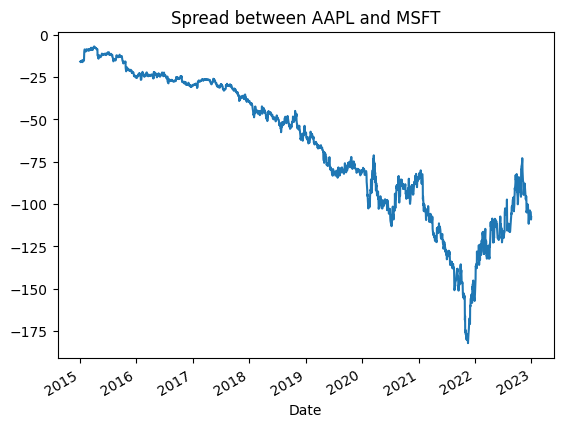

In [169]:
# Calculate the spread between the two stocks (Price Difference)
data['Spread'] = data['AAPL'] - data['MSFT']

# Optional: You can also use price ratios
# data['Spread'] = data['AAPL'] / data['MSFT']

# Visualize the spread
import matplotlib.pyplot as plt
data['Spread'].plot(title='Spread between AAPL and MSFT')
plt.show()

In [170]:
# Moving averages of the spread
data['Spread_MA_10'] = data['Spread'].rolling(window=10).mean()
data['Spread_MA_30'] = data['Spread'].rolling(window=30).mean()

# Volatility (rolling standard deviation)
data['Volatility'] = data['Spread'].rolling(window=30).std()

data.dropna(inplace=True)

## 4. Creating the Trading Environment:

In [171]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class PairsTradingEnv(gym.Env):
    def __init__(self, data):
        super(PairsTradingEnv, self).__init__()
        
        self.data = data
        self.current_step = 0
        self.done = False
        
        # Define action space: 0 = hold, 1 = long spread, 2 = short spread
        self.action_space = spaces.Discrete(3)  # 3 possible actions
        
        # Define observation space: spread, moving averages, volatility
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(3,), dtype=np.float32)
        
        # Initial balance and position
        self.position = 0  # 1 for long, -1 for short, 0 for neutral
        self.initial_balance = 10000
        self.balance = self.initial_balance

    def reset(self, seed=None, options=None):
        # Accepting a seed for reproducibility
        super().reset(seed=seed)
        np.random.seed(seed)
        
        self.current_step = 0
        self.position = 0
        self.balance = self.initial_balance
        return self._next_observation(), {}

    def _next_observation(self):
        # Get the relevant market data for the current step
        obs = self.data.iloc[self.current_step][['Spread', 'Spread_MA_10', 'Volatility']].values
        return obs.astype(np.float32)  # Cast to float32

    def step(self, action):
        # Simple stop-loss condition: If balance drops below a threshold, exit position
        if self.balance < self.initial_balance * 0.9:  # Stop-loss if the balance drops below 90% of initial balance
            reward = -10  # Reduced penalty
            terminated = True

        
        if self.current_step >= len(self.data) - 1:
            terminated = True
            truncated = False
            return self._next_observation(), 0, terminated, truncated, {}

        self.current_step += 1

        # Define termination and truncation conditions
        terminated = self.current_step >= len(self.data) - 1
        truncated = False  # No specific truncation condition

        # Initialize reward as 0 in case of no action
        reward = 0
        current_spread = self.data.iloc[self.current_step]['Spread']
        previous_spread = self.data.iloc[self.current_step - 1]['Spread']

        transaction_cost = abs(previous_spread - current_spread) * 0.1  # Transaction cost proportional to the spread


        # Calculate reward based on position and spread movement
        if action == 1:  # Long the spread
            reward = (previous_spread - current_spread) * 100 - transaction_cost
            self.position = 1
        elif action == 2:  # Short the spread
            reward = (current_spread - previous_spread) * 100 - transaction_cost
            self.position = -1
        else:  # Hold
            reward = 0

        # Penalize large drawdowns
        if reward < -10:
            reward = max(reward, -15)  # Cap the maximum loss instead of heavily penalizing

        # Update balance with the reward
        self.balance += reward

        return self._next_observation(), reward, terminated, truncated, {}


In [172]:
from stable_baselines3.common.env_checker import check_env

# Check the environment
env = PairsTradingEnv(data)
check_env(env)

## 5. Implementing the Reinforcement Learning Agent:

In [173]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor

# Wrapping your environment in Monitor and DummyVecEnv
env = Monitor(PairsTradingEnv(data))
env = DummyVecEnv([lambda: env])

# Initialize the PPO model
# model = PPO('MlpPolicy', env, learning_rate=0.0001, gamma=0.99, verbose=1)

from stable_baselines3 import A2C
model = PPO('MlpPolicy', env, learning_rate=0.0003, gamma=0.99, verbose=1)
model.learn(total_timesteps=100000)

# Train the agent
model.learn(total_timesteps=50000)  # Increase the number of training steps

# Save the trained model
model.save("ppo_pairs_trading")

Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.98e+03 |
|    ep_rew_mean     | 7.63e+04 |
| time/              |          |
|    fps             | 4020     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.98e+03   |
|    ep_rew_mean          | 7.8e+04    |
| time/                   |            |
|    fps                  | 3327       |
|    iterations           | 2          |
|    time_elapsed         | 1          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.01095112 |
|    clip_fraction        | 0.13       |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.09      |
|    explained_variance   | -6.77e-05  |
|    learning_rate        | 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.98e+03     |
|    ep_rew_mean          | 9.13e+04     |
| time/                   |              |
|    fps                  | 2896         |
|    iterations           | 11           |
|    time_elapsed         | 7            |
|    total_timesteps      | 22528        |
| train/                  |              |
|    approx_kl            | 0.0056581683 |
|    clip_fraction        | 0.0225       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.589       |
|    explained_variance   | 7.15e-07     |
|    learning_rate        | 0.0003       |
|    loss                 | 5.35e+05     |
|    n_updates            | 100          |
|    policy_gradient_loss | -0.0027      |
|    value_loss           | 1.19e+06     |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 1.98e+03      |
|    ep_rew_mean          | 1e+05         |
| time/                   |               |
|    fps                  | 2891          |
|    iterations           | 20            |
|    time_elapsed         | 14            |
|    total_timesteps      | 40960         |
| train/                  |               |
|    approx_kl            | 2.6861439e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.271        |
|    explained_variance   | 1.19e-07      |
|    learning_rate        | 0.0003        |
|    loss                 | 7.85e+05      |
|    n_updates            | 190           |
|    policy_gradient_loss | -1.62e-05     |
|    value_loss           | 1.37e+06      |
-------------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.98e+03     |
|    ep_rew_mean          | 1.05e+05     |
| time/                   |              |
|    fps                  | 2876         |
|    iterations           | 30           |
|    time_elapsed         | 21           |
|    total_timesteps      | 61440        |
| train/                  |              |
|    approx_kl            | 0.0005168189 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.313       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 7.33e+05     |
|    n_updates            | 290          |
|    policy_gradient_loss | -0.000307    |
|    value_loss           | 1.5e+06      |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.98e+03     |
|    ep_rew_mean          | 1.07e+05     |
| time/                   |              |
|    fps                  | 2877         |
|    iterations           | 40           |
|    time_elapsed         | 28           |
|    total_timesteps      | 81920        |
| train/                  |              |
|    approx_kl            | 0.0017718555 |
|    clip_fraction        | 0.00264      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.298       |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 6.99e+05     |
|    n_updates            | 390          |
|    policy_gradient_loss | -0.000986    |
|    value_loss           | 1.34e+06     |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.98e+03 |
|    ep_rew_mean     | 1.14e+05 |
| time/              |          |
|    fps             | 4209     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 1.98e+03      |
|    ep_rew_mean          | 1.13e+05      |
| time/                   |               |
|    fps                  | 3397          |
|    iterations           | 2             |
|    time_elapsed         | 1             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 0.00015656574 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.209        |
|    explained_variance   | 0             |


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 1.98e+03      |
|    ep_rew_mean          | 1.14e+05      |
| time/                   |               |
|    fps                  | 2959          |
|    iterations           | 11            |
|    time_elapsed         | 7             |
|    total_timesteps      | 22528         |
| train/                  |               |
|    approx_kl            | 0.00040788788 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.111        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 4.55e+05      |
|    n_updates            | 590           |
|    policy_gradient_loss | -0.000384     |
|    value_loss           | 1.27e+06      |
-------------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.98e+03     |
|    ep_rew_mean          | 1.14e+05     |
| time/                   |              |
|    fps                  | 2923         |
|    iterations           | 20           |
|    time_elapsed         | 14           |
|    total_timesteps      | 40960        |
| train/                  |              |
|    approx_kl            | 0.0001348547 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0759      |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 5.66e+05     |
|    n_updates            | 680          |
|    policy_gradient_loss | -0.000268    |
|    value_loss           | 1.35e+06     |
------------------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_l

## 6. Backtesting the Agent:

In [174]:
# Load the trained model
model = PPO.load("ppo_pairs_trading")

# Reset the environment
obs = env.reset()

# Test the agent on unseen data
total_reward = 0
for step in range(len(data)):
    # Predict action
    action, _ = model.predict(obs)
    
    # Take a step in the environment
    obs, reward, done, info = env.step(action)
    
    # Accumulate reward
    total_reward += reward

    # Print the action and reward for each step
    print(f"Step {step}: Action={action}, Reward={reward}")
    
    # Check if done and reset if needed
    if done:
        break

# Retrieve the environment's final balance directly from the unwrapped environment
final_balance = env.envs[0].unwrapped.balance

# Print the final balance and total reward accumulated
print(f"Final Balance: {final_balance+total_reward}")
print(f"Total Reward: {total_reward}")

Step 0: Action=[1], Reward=[-15.]
Step 1: Action=[1], Reward=[-15.]
Step 2: Action=[1], Reward=[3.4400837]
Step 3: Action=[1], Reward=[7.68655]
Step 4: Action=[1], Reward=[-15.]
Step 5: Action=[1], Reward=[13.365718]
Step 6: Action=[1], Reward=[66.918526]
Step 7: Action=[1], Reward=[-15.]
Step 8: Action=[1], Reward=[25.645716]
Step 9: Action=[1], Reward=[-11.512814]
Step 10: Action=[1], Reward=[-15.]
Step 11: Action=[1], Reward=[-0.7094795]
Step 12: Action=[1], Reward=[51.95338]
Step 13: Action=[1], Reward=[-15.]
Step 14: Action=[1], Reward=[30.344725]
Step 15: Action=[1], Reward=[-12.205492]
Step 16: Action=[1], Reward=[46.429317]
Step 17: Action=[0], Reward=[0.]
Step 18: Action=[1], Reward=[50.39473]
Step 19: Action=[1], Reward=[-14.856685]
Step 20: Action=[1], Reward=[-15.]
Step 21: Action=[1], Reward=[37.28091]
Step 22: Action=[1], Reward=[3.5098228]
Step 23: Action=[1], Reward=[86.850586]
Step 24: Action=[1], Reward=[-15.]
Step 25: Action=[1], Reward=[15.08938]
Step 26: Action=[1]

Step 681: Action=[1], Reward=[333.7952]
Step 682: Action=[1], Reward=[-15.]
Step 683: Action=[1], Reward=[-15.]
Step 684: Action=[1], Reward=[50.403114]
Step 685: Action=[1], Reward=[51.688526]
Step 686: Action=[1], Reward=[-15.]
Step 687: Action=[1], Reward=[-10.594461]
Step 688: Action=[1], Reward=[-15.]
Step 689: Action=[1], Reward=[-6.7763314]
Step 690: Action=[1], Reward=[-15.]
Step 691: Action=[1], Reward=[-6.667122]
Step 692: Action=[1], Reward=[22.004036]
Step 693: Action=[1], Reward=[72.95401]
Step 694: Action=[1], Reward=[-7.1276345]
Step 695: Action=[1], Reward=[-15.]
Step 696: Action=[1], Reward=[-15.]
Step 697: Action=[1], Reward=[16.05906]
Step 698: Action=[1], Reward=[36.018555]
Step 699: Action=[1], Reward=[-15.]
Step 700: Action=[1], Reward=[13.674209]
Step 701: Action=[1], Reward=[77.279366]
Step 702: Action=[1], Reward=[117.66938]
Step 703: Action=[1], Reward=[-15.]
Step 704: Action=[1], Reward=[21.218613]
Step 705: Action=[1], Reward=[27.170069]
Step 706: Action=[1]

Step 1500: Action=[1], Reward=[530.8788]
Step 1501: Action=[1], Reward=[-15.]
Step 1502: Action=[1], Reward=[440.37338]
Step 1503: Action=[1], Reward=[-15.]
Step 1504: Action=[1], Reward=[60.00311]
Step 1505: Action=[1], Reward=[11.432648]
Step 1506: Action=[1], Reward=[213.93533]
Step 1507: Action=[1], Reward=[-15.]
Step 1508: Action=[1], Reward=[187.05489]
Step 1509: Action=[1], Reward=[24.871344]
Step 1510: Action=[1], Reward=[88.68991]
Step 1511: Action=[1], Reward=[332.9614]
Step 1512: Action=[1], Reward=[70.90833]
Step 1513: Action=[1], Reward=[-15.]
Step 1514: Action=[1], Reward=[-15.]
Step 1515: Action=[1], Reward=[-15.]
Step 1516: Action=[1], Reward=[174.08417]
Step 1517: Action=[1], Reward=[-15.]
Step 1518: Action=[1], Reward=[302.32114]
Step 1519: Action=[1], Reward=[-15.]
Step 1520: Action=[1], Reward=[-15.]
Step 1521: Action=[1], Reward=[-15.]
Step 1522: Action=[2], Reward=[-15.]
Step 1523: Action=[1], Reward=[345.95572]
Step 1524: Action=[1], Reward=[87.29513]
Step 1525: 

## 7. Performance Evaluation:

Evaluating the performance of agent by comparing its returns against benchmarks like the buy-and-hold strategy. 

### a. Cumulative Returns: Plot the agent's cumulative returns over time.

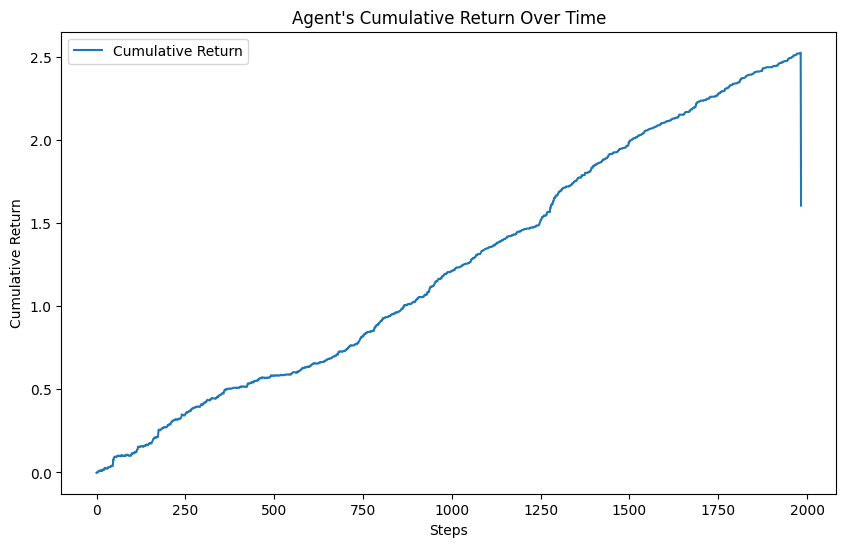

In [175]:
import matplotlib.pyplot as plt
import numpy as np

# Load the trained model
model = PPO.load("ppo_pairs_trading")

# Reset the environment
obs = env.reset()

# Initialize variables to track performance
initial_balance = 10000  # Use the same initial balance from the environment
balance_history = [initial_balance]  # Track the balance at each step
returns = []  # To store individual returns

# Test the agent on unseen data
for step in range(len(data)):
    # Predict action
    action, _ = model.predict(obs)
    
    # Take a step in the environment
    obs, reward, done, info = env.step(action)
    
    # Access the balance after the step
    current_balance = env.envs[0].unwrapped.balance
    balance_history.append(current_balance)
    
    # Calculate percentage return for this step
    step_return = (current_balance - balance_history[-2]) / balance_history[-2]
    returns.append(step_return)

    # Check if done and reset if needed
    if done:
        break

# Calculate Cumulative Returns
cumulative_returns = np.cumsum(returns)

# Plotting the Cumulative Returns
plt.figure(figsize=(10,6))
plt.plot(cumulative_returns, label='Cumulative Return')
plt.title("Agent's Cumulative Return Over Time")
plt.xlabel('Steps')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

### b. Sharpe Ratio: Measures risk-adjusted returns.

In [176]:
import numpy as np

# Assuming returns have been calculated as in the cumulative return code
# Risk-free rate (can be 0 or any other rate)
risk_free_rate = 0.0

# Convert list of returns to a numpy array for easier calculation
returns = np.array(returns)

# Calculate the average return (mean of returns)
average_return = np.mean(returns)

# Calculate the standard deviation of returns (volatility)
std_deviation = np.std(returns)

# Sharpe ratio calculation
if std_deviation != 0:
    sharpe_ratio = (average_return - risk_free_rate) / std_deviation
else:
    sharpe_ratio = 0  # To avoid division by zero if there's no volatility

# Print the Sharpe Ratio
print(f"Sharpe Ratio: {sharpe_ratio}")


Sharpe Ratio: 0.038783062445579324


### c.Drawdown: Shows the largest peak-to-trough loss during the backtest.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you already have the balance_history from your trading loop

# Example of balance_history
# balance_history = [10000, 10200, 10100, 9800, 10500, 10400, ...]

# Convert balance history to numpy array for easier manipulation
balance_history = np.array(balance_history)

# Calculate the running maximum balance at each time step
running_max = np.maximum.accumulate(balance_history)

# Calculate drawdowns: difference between running maximum and current balance
drawdowns = running_max - balance_history

# Calculate the maximum drawdown
max_drawdown = np.max(drawdowns)

# Print the maximum drawdown
print(f"Maximum Drawdown: {max_drawdown}")

# Plot balance and drawdown
plt.figure(figsize=(10,6))

# Plot balance history
plt.plot(balance_history, label="Balance", color='blue')

# Plot drawdowns
plt.plot(running_max, label="Running Max", linestyle='--', color='orange')
plt.fill_between(range(len(balance_history)), balance_history, running_max, color='red', alpha=0.3, label="Drawdown")

plt.title("Balance


## 8. Extensions and Improvements: